In [1]:
import numpy as np
from legate.timing import time
import cunumeric as cu
import scipy as sc
import pyfftw
from tqdm import tqdm
import matplotlib.pyplot as plt
from ternay_utils  import (
    ternary_numpy,
    ternary_scipy,
    ternary_pyfftw,
    ternary_cunumeric_naive,
    ternary_cunumeric_optimized
)
# Set random seed for reproducibility
np.random.seed(714)
cu.random.seed(714)

In [2]:
sizes = [16, 32, 64, 128, 256, 512, 1024]
NUM_ITER = 2000

# Measure time taken for each size
time_numpy = []
time_pyfftw = []
time_scipy = []
time_cunumeric_naive = []
time_cunumeric_optimized = []

for size in tqdm(sizes):
    time_numpy.append(ternary_numpy(size, num_iter=NUM_ITER))
    time_pyfftw.append(ternary_pyfftw(size, num_iter=NUM_ITER))
    time_scipy.append(ternary_scipy(size, num_iter=NUM_ITER))
    time_cunumeric_naive.append(ternary_cunumeric_naive(size, num_iter=NUM_ITER))
    time_cunumeric_optimized.append(ternary_cunumeric_optimized(size, num_iter=NUM_ITER))
    # print(f'size {size} done')

  0%|          | 0/7 [00:00<?, ?it/s]

/home/co21btech11001/main/CMS_Lab_GPU_Codes/aaryan/notebooks/ternay_utils.py:99: RuntimeWarning: cuNumeric has not implemented numpy.fft.rfftfreq and is falling back to canonical numpy. You may notice significantly decreased performance for this function call.
  kx = 2 * cu.pi * cu.fft.rfftfreq(Nx, d=dx)
/home/co21btech11001/main/CMS_Lab_GPU_Codes/aaryan/notebooks/ternay_utils.py:100: RuntimeWarning: cuNumeric has not implemented numpy.fft.fftfreq and is falling back to canonical numpy. You may notice significantly decreased performance for this function call.
  ky = 2 * cu.pi * cu.fft.fftfreq(Ny, d=dy)
/home/co21btech11001/main/CMS_Lab_GPU_Codes/aaryan/notebooks/ternay_utils.py:176: RuntimeWarning: cuNumeric has not implemented numpy.fft.rfftfreq and is falling back to canonical numpy. You may notice significantly decreased performance for this function call.
  kx = 2 * cu.pi * cu.fft.rfftfreq(Nx, d=dx)
/home/co21btech11001/main/CMS_Lab_GPU_Codes/aaryan/notebooks/ternay_utils.py:177: 

100%|██████████| 7/7 [39:34<00:00, 339.24s/it]


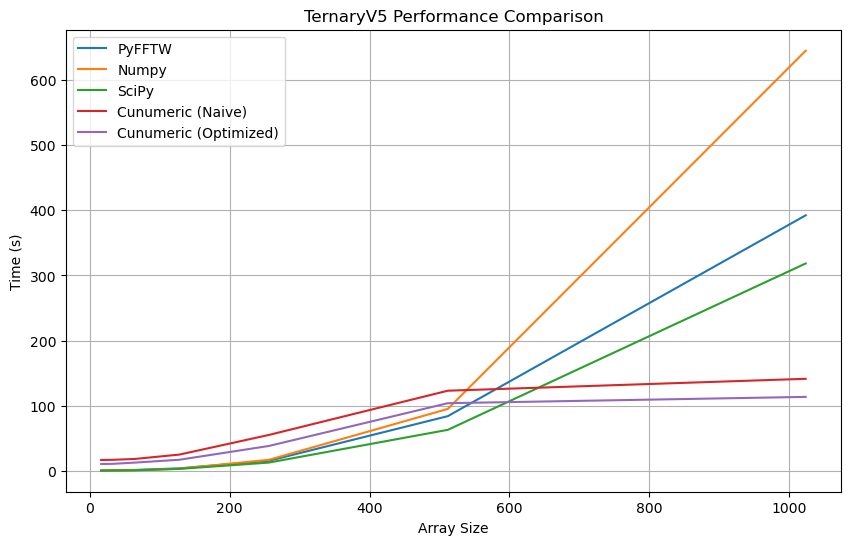

In [3]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_pyfftw, label='PyFFTW')
plt.plot(sizes, time_numpy, label = 'Numpy')
plt.plot(sizes, time_scipy, label='SciPy')
plt.plot(sizes, time_cunumeric_naive, label='Cunumeric (Naive)')
plt.plot(sizes, time_cunumeric_optimized, label='Cunumeric (Optimized)')
plt.title('TernaryV5 Performance Comparison')
plt.xlabel('Array Size')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
print("Numpy:")
print(time_numpy)
print("PyFFTW:")
print(time_pyfftw)
print("SciPy:")
print(time_scipy)
print("Cunumeric Naive:")
print(time_cunumeric_naive)
print("Cunumeric Optimized:")
print(time_cunumeric_optimized)

Numpy:
[0.44224137599999835, 0.5873940250000089, 1.1248542579999992, 3.5576360809999983, 17.187763665999995, 95.28284604199996, 644.8504179960001]
PyFFTW:
[1.0389305240000084, 1.169834741999992, 1.621452541999986, 4.061181680000004, 15.694494329999998, 84.16085663800004, 392.284861741]
SciPy:
[0.4330031289999994, 0.6532448860000102, 1.070935167000016, 3.230180604000026, 12.937462449000009, 63.17309887399995, 318.44312868900033]
Cunumeric Naive:
[16.932183259, 17.142643046999993, 18.49197744600002, 25.19377504000002, 55.319915976000004, 123.20281858299995, 141.46669405700004]
Cunumeric Optimized:
[10.726829518999992, 10.97806736999999, 12.873946329999995, 17.28361801700001, 38.43747792400001, 104.05588339400003, 113.71827124299989]


# Key takeaways:
- While using cunumeric, for every operation ```+```, ```-```, ```*```, ```/``` etc. data is transferred to CPU to GPU and back to CPU. This introduces a lot of overhead.
- For smaller arrays, the overhead of data transfer is more than the actual computation time. Therefore, Scipy takes 0.43s for the simulation while Cunumeric takes 10.72s for a grid of size 16x16.
- For larger arrays, the overhead of data transfer is less than the actual computation time. Therefore, Scipy takes 318s for the simulation while Cunumeric takes 113s for a grid of size 1024x1024.
- **Important**: The performance of Cunumeric can be improved by restructuring the equations to reduce the number of data transfers between CPU and GPU.
- In ```ternary_cunumeric_optimized``` function, the equations are restructured in the following way:<br><br>
    - $
    g_A = 2 A_1  c_A  c_B^2 - 2  A_2  c_B^2  c_C - 2 A_3  c_A^2  c_C + 2  A_3  c_A  c_C^2 - 2  B  c_A^2 c_B^2  c_C + 2  B  c_A  c_B^2  c_C^2
    $
    <br>
    $
    g_B = 2 A_1 c_A^2 c_B - 2 A_2 c_B^2 c_C + 2 A_2 c_B c_C^2 - 2 A_3 c_A^2 c_C - 2 B c_A^2 c_B^2 c_C + 2 B c_A^2 c_B c_C^2
    $
    <br><br>
    Restructured equations:
    <br><br>
    $
    g_A = 2 c_B^2 (A_1 c_A - A_2 c_C) + 2 A_3 c_A c_C (c_C - c_A) + 2 B c_A c_B^2 c_C (c_C - c_A)
    $
    <br>
    $
    g_B = 2 c_A^2 (A_1 c_B - A_3 c_C) + 2 A_2 c_B c_C (c_C - c_B) + 2 B c_A^2 c_B c_C (c_C - c_B)
    $
    <br>
    <br>
    - Cunumeric's performance can be increased by using the restructured equations. Reference: https://nv-legate.github.io/cunumeric/23.11/user/practices.html#merge-tasks
- The naive function ```ternary_cunumeric_naive```, which uses the original equations, takes 141s for a grid of size 1024x1024. The optimized function ```ternary_cunumeric_optimized```, which uses the restructured equations, takes 113s for the same grid size.
- Inbuilt Cunumeric functions like ```cunumeric.add``` and ```cunumeric.multiply``` perform better than the operators like ```+``` and ```*```.